TODO

add description

In [10]:
import pandas as pd
from datetime import datetime

Time series regression models is a statistical method for predicting a future response based on response history.

For this example, we are going to use ```Beijing PM2.5 Dataset```. The dataset contains hourly data of the PM2.5 from US Embassy in Beijing. PM2.5 is a common measurement used to measures air quality.

The objective is we are going forecast the PM2.5 value for the upcoming next week.
	
more about the dataset: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

In [71]:
air = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')
air.index = pd.to_datetime(air[['year', 'month', 'day']])
air

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
2014-12-31,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


table above shows the summary of beijing air pollution dataset. ```pm2.5``` is the value of interest $y$, and ```dewp, temp, pres, cbwd, lwd, ls, lr``` are the predictors $x$.

## Descriptive Analysis

Before we start, lets quickly check the distribution, missing values, and unique values of our dataset

In [72]:
#remove unused column
air = air.drop("No", axis=1)

In [73]:
air.describe()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [74]:
def get_missing_value_and_unique_count(dataframe):
    missing_value_count = dataframe.isna().sum()
    unique_count = dataframe.apply(lambda x: len(x.unique()))
    
    return pd.DataFrame({'missing_value': missing_value_count,'unique': unique_count})

In [75]:
# check missing values and unique count
get_missing_value_and_unique_count(air)

,missing_value,unique
year,0,5
month,0,12
day,0,31
hour,0,24
pm2.5,2067,582
DEWP,0,69
TEMP,0,64
PRES,0,60
cbwd,0,4
Iws,0,2788


In [76]:
air.apply(set)

year                        {2010, 2011, 2012, 2013, 2014}
month              {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
day      {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
hour     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
pm2.5    {nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
DEWP     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
TEMP     {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
PRES     {1024.0, 1025.0, 1026.0, 1027.0, 1028.0, 1029....
cbwd                                      {NE, SE, cv, NW}
Iws      {2.25, 4.91, 4.02, 6.25, 7.16, 8.93, 9.84, 8.5...
Is       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Ir       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
dtype: object

In [77]:
air[air['pm2.5'].isna()][23:]

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01,2010,1,1,23,NaN,-17,-5.0,1020.0,cv,0.89,0,0
2010-01-23,2010,1,23,17,NaN,-18,2.0,1024.0,NW,91.22,0,0
2010-01-23,2010,1,23,18,NaN,-18,1.0,1024.0,NW,96.14,0,0
2010-01-23,2010,1,23,19,NaN,-17,0.0,1024.0,NW,100.16,0,0
2010-01-23,2010,1,23,20,NaN,-18,0.0,1024.0,SE,1.79,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-20,2014,12,20,12,NaN,-18,0.0,1030.0,NW,244.97,0,0
2014-12-20,2014,12,20,13,NaN,-19,1.0,1029.0,NW,249.89,0,0
2014-12-20,2014,12,20,14,NaN,-20,1.0,1029.0,NW,257.04,0,0
2014-12-20,2014,12,20,15,NaN,-20,2.0,1028.0,NW,262.85,0,0


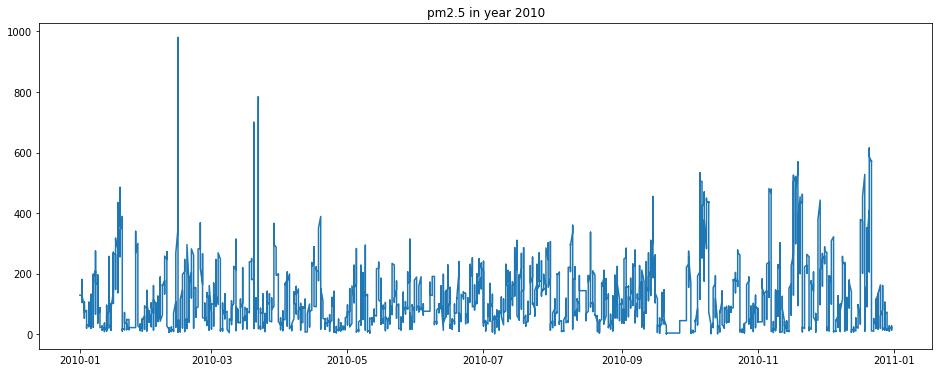

In [110]:
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(16,6))

air_2010 = air[air['year']==2010]

plt.plot(air_2010['pm2.5'])
plt.title("pm2.5 in year 2010")

plt.show()

## Impute Missing Values

Since there are missing values in ```pm2.5```, we can fill it with some value.

There are several ways to do a value imputation.

***Non-time-series specific method***

- Mean imputation
- Median imputation
- Mode imputation 
- Random sample imputation (replace missing values with observations randomly selected from the remaining (either of it or just some section of it)

*These method can be use if series has no trend and seasonality*

***Time-Series specific method***

- Last observation carried forward (LOCF)
- Next observation carried backward (NOCB)
- Linear interpolation or Spline interpolation

*Interpolation methods rely on the assumption that adjacent observations are similar to one another,  do not work well when this assumption is not valid, especially when the presence of strong seasonality*

Lets impute the missing value using LOCF

In [100]:
# imputation using LOCF
air['pm2.5'] = air['pm2.5'].fillna(method='ffill')
air['pm2.5'] = air['pm2.5'].fillna(method='bfill')

In [101]:
air2 = air[['pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']]

In [105]:
air['year'].name

'year'

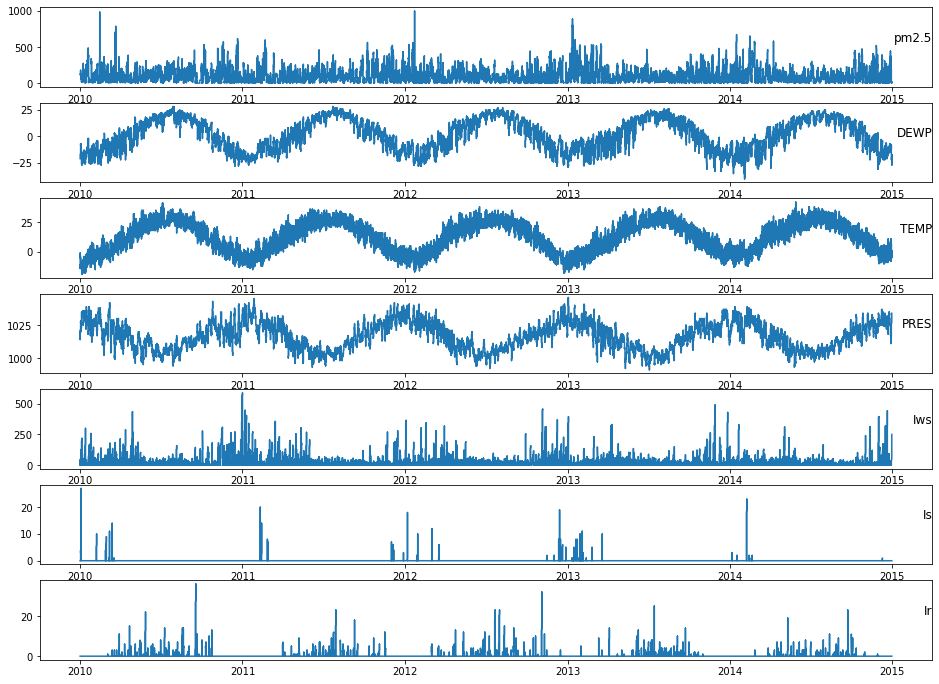

In [107]:
# specify columns to plot
groups = ['pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
i = 1
# plot each column
plt.figure(figsize=(16,12))
for group in groups:
    series = air[group]
    plt.subplot(len(groups), 1, i)
    plt.plot(series)
    plt.title(series.name, y=0.5, loc='right')
    i += 1
    
plt.show()

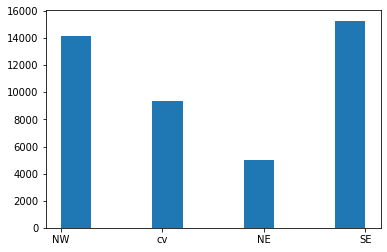

In [114]:
plt.rc('figure',figsize=(6, 4))

plt.hist(air['cbwd'])
plt.show()

In [91]:
hour_1 = air[(air['hour']==2) & (air['day']==1) & (air['month']==1)]

In [92]:
hour_1

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2011-01-01,2011,1,1,2,NaN,-21,-11.0,1033.0,NW,577.56,0,0
2012-01-01,2012,1,1,2,215.0,-13,-9.0,1032.0,NW,3.58,0,0
2013-01-01,2013,1,1,2,32.0,-11,-7.0,1017.0,NW,11.62,0,0
2014-01-01,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0


In [18]:
# load data
def date_parser(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('data/BeijingPollution/raw.txt',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=date_parser)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# save to file
dataset.to_csv('data/BeijingPollution/pollution.csv')

In [23]:
# summarize first 5 rows
dataset.head(8)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0


In [22]:
dataset.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

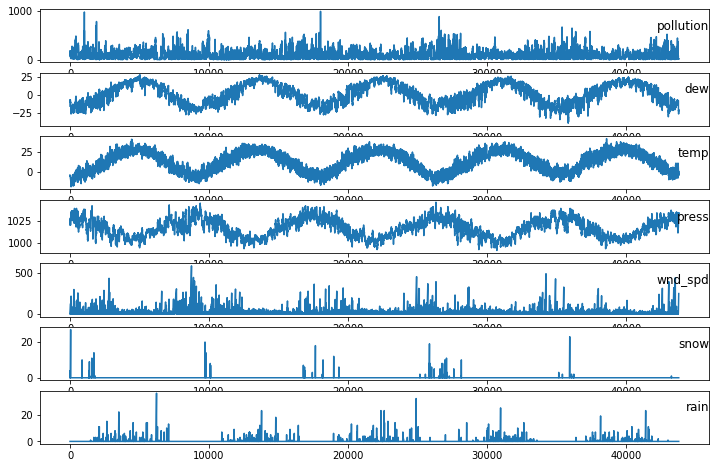

In [3]:
# load dataset
dataset = read_csv('data/BeijingPollution/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(12,8))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
    
pyplot.show()

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('data/BeijingPollution/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   
2      148.0      -15.0       -4.0     1020.0        2.0       2.68   
3      159.0      -11.0       -5.0     1021.0        2.0       3.57   
4      181.0       -7.0       -5.0     1022.0        2.0       5.36   
5      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-1)  var8(t-1)  var1(t)  
1        0.0        0.0    148.0  
2        0.0        0.0    159.0  
3        0.0        0.0    181.0  
4        1.0        0.0    138.0  
5        2.0        0.0    109.0  


In [5]:
values.shape

(43800, 8)

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 8) (35040,) (8759, 8) (8759,)


In [7]:
# prepare a list of ml models
def get_linear_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    print('----------------- Defined %d models' % len(models))
    return models

# prepare a list of ml models
def get_nonlinear_models(models=dict()):
    # non-linear models
    models['knn'] = KNeighborsRegressor(n_neighbors=7)
    models['cart'] = DecisionTreeRegressor()
    models['extra'] = ExtraTreeRegressor()
    models['svmr'] = SVR()
    print('----------------- Defined %d models' % len(models))
    return models

# prepare a list of ml models
def get_ensemble_models(models=dict()):
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    print('----------------- Defined %d models' % len(models))
    return models

In [8]:
# fit one model for each variable and each forecast
def fit_model(model, train_X, train_y):
    # clone the model configuration
    local_model = clone(model)
    # fit the model
    return local_model.fit(train_X, train_y)

# return forecasts as [chunks][var][time]
def make_predictions(model, test_X):
    return array(model.predict(test_X))

def calculate_error(actual, predicted):
    # give the full actual value if predicted is nan
    if isnan(predicted):
        return abs(actual)
    # calculate abs difference
    return abs(actual - predicted)

def evaluate_forecasts(predictions, testset):
    total_mae = 0.0
    total_c = 0
    # convert to forecasts
    actual = testset
    predicted = predictions
    # enumerate target variables
    for j in range(predicted.shape[0]):
        # skip if actual in nan
        if isnan(actual[j]):
            continue
        # calculate error
        error = calculate_error(actual[j], predicted[j])
        # update statistics
        total_mae += error
        total_c += 1
    # normalize summed absolute errors
    total_mae /= total_c
    return total_mae

# summarize scores
def summarize_error(name, total_mae):
    print('%s: %.3f MAE' % (name, total_mae))
    
# evaluate a suite of models
def evaluate_models(models, train_X, train_y, test_X, test_y):
    pdict = dict()
    for name, model in models.items():
        # fit models
        fits = fit_model(model, train_X, train_y)
        # make predictions
        predictions = make_predictions(fits, test_X)
        # evaluate forecast
        mae = evaluate_forecasts(predictions, test_y)
        # summarize forecast
        summarize_error(name, mae)
        # keep results
        d = dict()
        d["predictions"] = predictions
        d["mae"] = mae
        pdict[name] = d
    return pdict
        
# linear models
print("\n Linear Models")
pdict_linear = evaluate_models(get_linear_models(), train_X, train_y, test_X, test_y)

# nonlinear models
print("\n Nonlinear Models")
pdict_nonlinear = evaluate_models(get_nonlinear_models(), train_X, train_y, test_X, test_y)

# ensemble models
print("\n Ensemble Models")
pdict_ensemble = evaluate_models(get_ensemble_models(), train_X, train_y, test_X, test_y)



 Linear Models
----------------- Defined 8 models
lr: 12.786 MAE
lasso: 12.718 MAE
ridge: 12.786 MAE
en: 12.721 MAE


D:\Programs_Dir\Anaconda3\envs\statsmodels\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


huber: 12.348 MAE
llars: 68.116 MAE
pa: 20.615 MAE
sgd: 90142808448588.156 MAE

 Nonlinear Models
----------------- Defined 4 models
knn: 14.267 MAE
cart: 21.402 MAE
extra: 20.172 MAE
svmr: 12.833 MAE

 Ensemble Models
----------------- Defined 5 models
ada: 20.445 MAE
bag: 14.019 MAE
rf: 14.029 MAE
et: 14.458 MAE
gbm: 12.481 MAE


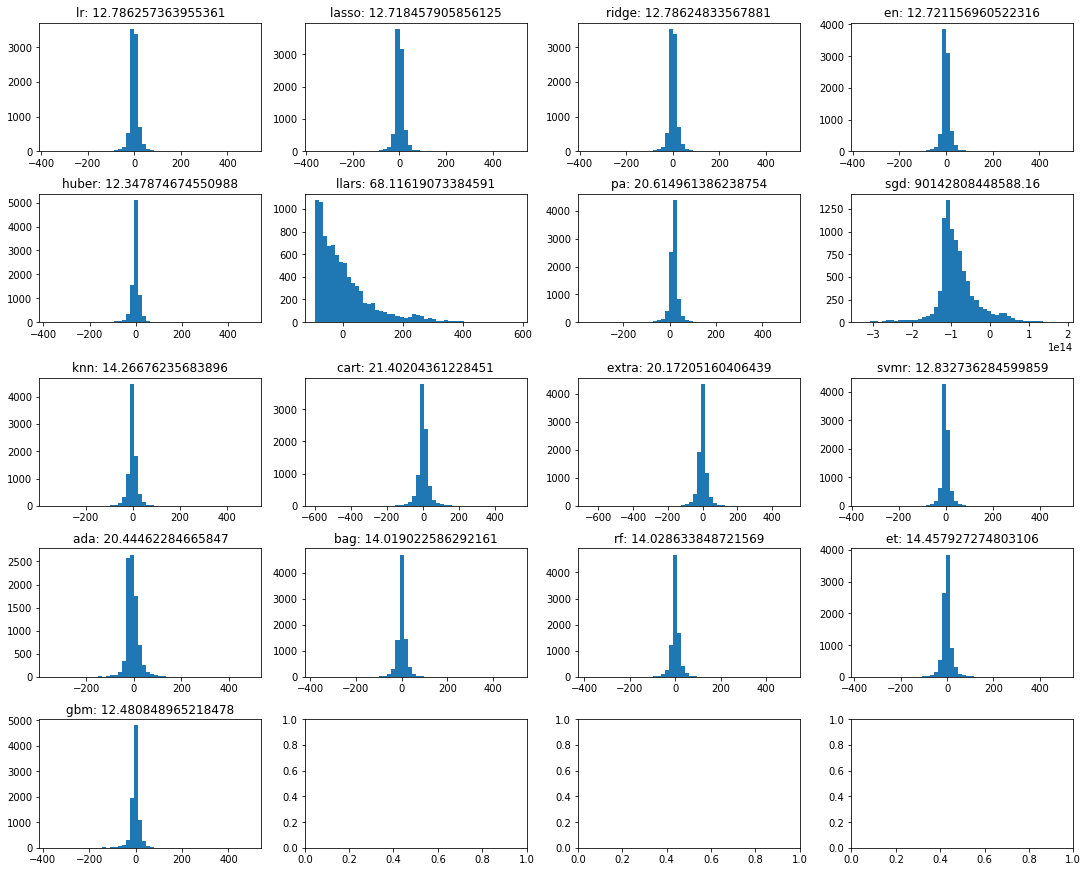

In [9]:
res = {**pdict_linear, **pdict_nonlinear, **pdict_ensemble}

n_bins = 50
fig, axs = pyplot.subplots(5, 4, sharey=False, constrained_layout=True, figsize=(15,12))
for index, key in enumerate(res):
    axs[int(index/4)][int(index%4)].title.set_text(key + ": " + str(res[key]["mae"]))
    axs[int(index/4)][int(index%4)].hist(test_y-res[key]["predictions"], bins=n_bins)

## Linear model forecast (huber, lowest MAE)

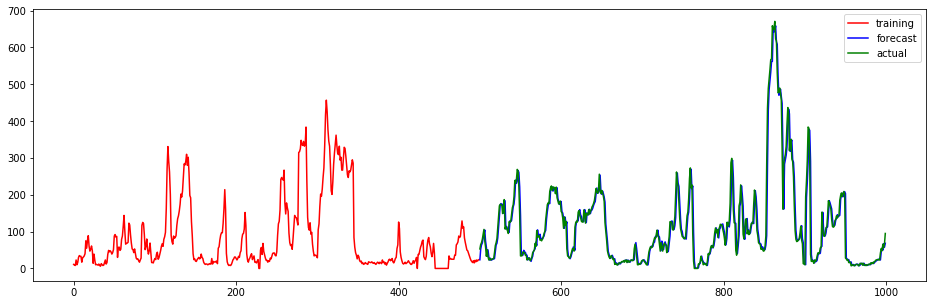

In [10]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_linear["huber"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Non-Linear model forecast (svmr, lowest MAE)

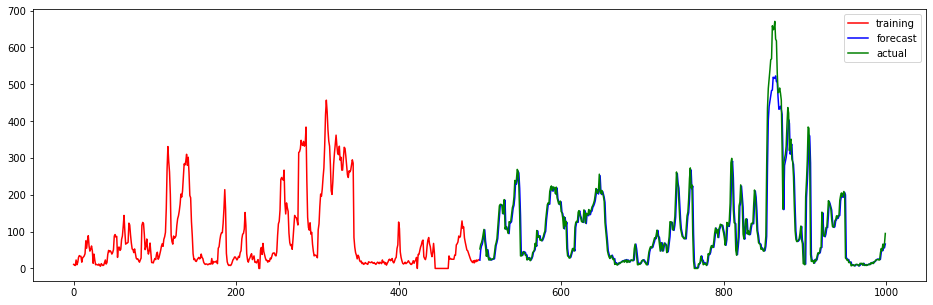

In [11]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_nonlinear["svmr"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Ensemble model forecast (gbm, lowest MAE)

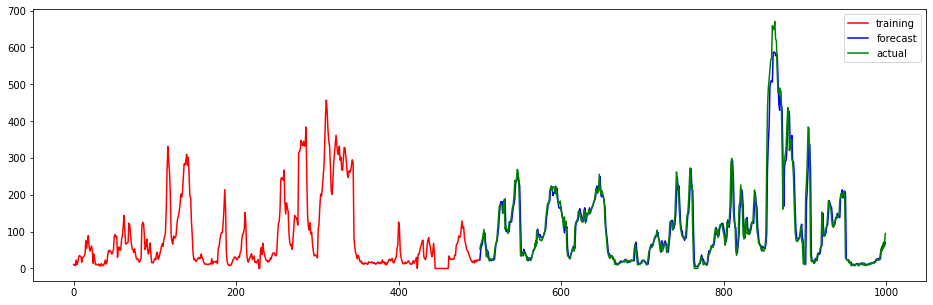

In [12]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_ensemble["gbm"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Ensemble model forecast (ada, highest MAE)

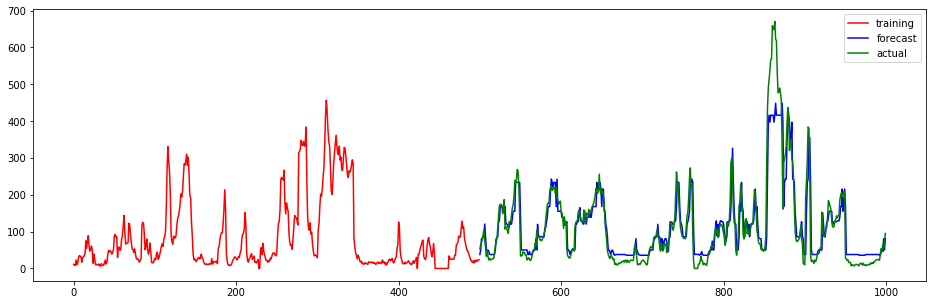

In [13]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_ensemble["ada"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Stationarity
-19.094697 is lesser than -3.431. This suggests that we can reject the null hypothesis with a significance level of less than 1%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(training_arr)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -4.276495
p-value: 0.000488
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
